# <span style="color:green"><center>Diplomado en Big Data</center></span>

# <span style="color:red"><center>Procesamiento Paralelo. Ejecución perezosa<center></span>

<img src="http://dask.readthedocs.io/en/latest/_images/dask_horizontal.svg"
     align="right"
     width="30%"
     alt="Dask logo\">

# Ejecución perezosa con  `dask.delayed`

##   <span style="color:blue">Profesores</span>

1. Alvaro Mauricio Montenegro Díaz, ammontenegrod@unal.edu.co
2. Daniel Mauricio Montenegro Reyes, dextronomo@gmail.com 
3. Campo Elías Pardo Turriago, cepardot@unal.edu.co 

##   <span style="color:blue">Asesora Medios y Marketing digital</span>
 

4. Maria del Pilar Montenegro, pmontenegro88@gmail.com 

## <span style="color:blue">Contenido</span>

* [Introducción](#Introducción)
* [Ejecución perzosa](#Ejecución-perzosa)
* [Dask es un motor de ejecución perezosa de grafos](#Dask-es-un-motor-de-ejecución-perezosa-de-grafos)
* [¿Por qué debería preocuparse por la ejecución perezosa?](#¿Por-qué-debería-preocuparse-por-la-ejecución-perezosa?)
* [Ejercicio](#Ejercicio)


## <span style="color:blue">Fuente</span>

Esta es una traducción libre del tutorial disponible en [dask-tutorial](https://github.com/dask/dask-tutorial).

## <span style="color:blue">Introducción</span>

El objetivo de `Dask` es hacer que las cosas simples sean fáciles y que las complejas sean posibles.

Podemos resumir los conceptos básicos de Dask de la siguiente manera:

- procesar datos que no caben en la memoria dividiéndolos en bloques y especificando cadenas de tareas
- paralelizar la ejecución de tareas en los núcleos e incluso en los nodos de un clúster
- mover el cálculo a los datos en lugar de al revés, para minimizar la sobrecarga de comunicación

Todo esto le permite aprovechar al máximo sus recursos de computación, pero programar de una manera que sea muy familiar: bucles for para construir tareas básicas, iteradores de Python y las funciones NumPy (matriz) y Pandas (marco de datos) para múltiples -datos dimensionales o tabulares, respectivamente.

El resto de este cuaderno lo llevará a través del primero de estos paradigmas de programación. Esto es más detallado de lo que querrán algunos usuarios, que pueden saltar a las secciones de iterador, matriz y marco de datos; pero habrá algunas tareas de procesamiento de datos que no encajan fácilmente en esas abstracciones y deben recurrir a los métodos aquí.

Incluimos algunos ejemplos al final de los cuadernos que muestran que las ideas detrás de cómo se construye Dask no son realmente tan novedosas, y los programadores experimentados habrán conocido partes del diseño en otras situaciones antes. Esos ejemplos se dejan para los interesados.

## <span style="color:blue">Ejecución perzosa</span>

Aquí discutimos algunos de los conceptos detrás de `dask` y la ejecución diferida de código.


## <span style="color:blue">Dask es un motor de ejecución perezosa de grafos</span> 

`Dask` permite construir una prescripción para el cálculo que desea realizar. Eso puede sonar extraño, pero un ejemplo simple demostrará que puede lograrlo mientras programa con funciones perfectamente ordinarias de Python y bucles for. Vimos esto en el cuaderno anterior.

In [1]:
from dask import delayed

@delayed
def inc(x):
    return x + 1

@delayed
def add(x, y):
    return x + y

Aquí hemos utilizado la anotación retrasada para mostrar que queremos que estas funciones funcionen de forma perezosa, para guardar el conjunto de entradas y ejecutarlas solo bajo demanda. `dask.delayed` también es una función que puede hacer esto, sin la anotación, dejando la función original sin cambios, por ejemplo,

```python
     delayed_inc = delayed(inc)
```

In [2]:
# this looks like ordinary code
x = inc(15)
y = inc(30)
total = add(x, y)
# x, y and total are all delayed objects. 
# They contain a prescription of how to carry out the computation

Llamar a una función retrasada creando un objeto retrasado (`x, y, total`) que se puede examinar de forma interactiva. Hacer estos objetos es algo equivalente a construcciones como `lambda` o envoltorios de funciones (ver más abajo). Cada uno tiene un diccionario simple que describe el gráfico de la tarea, una especificación completa de cómo llevar a cabo el cálculo.

Podemos visualizar la cadena de cálculos a la que corresponde el objeto `total` de la siguiente manera; los círculos son funciones, los rectángulos son datos / resultados.

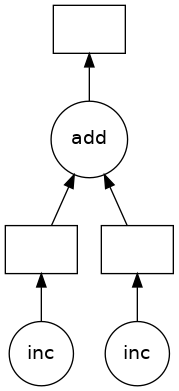

In [3]:
total.visualize()

Pero hasta ahora, no se ha ejecutado ninguna función. Esto demostró la división entre la parte de creación de gráficos de Dask (`retrasado ()`, en este ejemplo) y la parte de ejecución de gráficos de Dask.

Para ejecutar el "gráfico" en la visualización y obtener un resultado, haga lo siguiente:

In [7]:
# execute all tasks
total.compute()

47

## <span style="color:blue">¿Por qué debería preocuparse por la ejecución perezosa?</span> 

Al construir una especificación del cálculo que queremos realizar antes de ejecutar cualquier cosa, podemos pasar la especificación a un *motor de ejecución* para su evaluación. 

En el caso de Dask, este motor de ejecución podría estar ejecutándose en muchos nodos de un clúster, por lo que tiene acceso a la cantidad total de núcleos de CPU y memoria en todas las máquinas. 

*Dask* ejecutará inteligentemente su cálculo con cuidado para minimizar la cantidad de datos almacenados en la memoria, mientras paraleliza las tareas que componen un gráfico. 

Observe que en el diagrama animado a continuación, donde cuatro trabajadores están procesando el gráfico (simple), la ejecución progresa verticalmente hacia arriba en las ramas primero, de modo que los resultados intermedios se pueden borrar antes de pasar a una nueva rama.

Con código en bucle pythonico o normal y "retrasado", se pueden construir gráficos muy complejos y pasarlos a *Dask* para su ejecución. Vea un buen ejemplo de flujo de trabajo [ETL complejo simulado](https://blog.dask.org/2017/01/24/dask-custom).


![this](../images/grid_search_schedule.gif)

## <span style="color:blue">Ejercicio</span> 

Aplicaremos el retraso a una tarea de procesamiento de datos real, aunque sea simple.

Considere leer tres archivos CSV con pd.read_csv y luego medir su longitud total. 

Consideraremos cómo haría esto con código Python ordinario, luego construiremos un gráfico para este proceso usando retardado, y finalmente ejecutaremos este gráfico usando Dask, para un factor de aceleración útil de más de dos (solo hay tres entradas para paralelizar terminado).

In [ ]:
%run prep.py -d accounts

In [5]:
import pandas as pd
import os
filenames = [os.path.join('../data', 'accounts.%d.csv' % i) for i in [0, 1, 2]]
filenames

['../data/accounts.0.csv', '../data/accounts.1.csv', '../data/accounts.2.csv']

In [6]:
%%time

# normal, sequential code
a = pd.read_csv(filenames[0])
b = pd.read_csv(filenames[1])
c = pd.read_csv(filenames[2])

na = len(a)
nb = len(b)
nc = len(c)

total = sum([na, nb, nc])
print(total)

3000000
CPU times: user 1.05 s, sys: 216 ms, total: 1.27 s
Wall time: 1.45 s


Su tarea es volver a crear este gráfico utilizando la función retrasada en el código Python original. Las tres funciones que desea retrasar son `pd.read_csv`, `len` and `sum`.. 

```python
delayed_read_csv = delayed(pd.read_csv)
a = delayed_read_csv(filenames[0])
...

total = ...

# execute
%time total.compute()   
```

In [ ]:
# your verbose code here

A continuación, repita esto usando bucles, en lugar de escribir todas las variables.

In [ ]:
# your concise code here

In [7]:
## verbose version
delayed_read_csv = delayed(pd.read_csv)
a = delayed_read_csv(filenames[0])
b = delayed_read_csv(filenames[1])
c = delayed_read_csv(filenames[2])

delayed_len = delayed(len)
na = delayed_len(a)
nb = delayed_len(b)
nc = delayed_len(c)

delayed_sum = delayed(sum)

total = delayed_sum([na, nb, nc])
%time print(total.compute())


## concise version
csvs = [delayed(pd.read_csv)(fn) for fn in filenames]
lens = [delayed(len)(csv) for csv in csvs]
total = delayed(sum)(lens)
%time print(total.compute())


3000000
CPU times: user 1.29 s, sys: 276 ms, total: 1.56 s
Wall time: 940 ms
3000000
CPU times: user 1.32 s, sys: 116 ms, total: 1.44 s
Wall time: 692 ms


### Notas

Los objetos Delayed soporta varios tipos de operaciones:

```python
    x2 = x + 1
```

Si x fue un resultado retrasado (como el total, arriba), entonces también lo es x2. Las operaciones admitidas incluyen operadores aritméticos, selección de elementos o sectores, acceso a atributos y llamadas a métodos, esencialmente cualquier cosa que pueda expresarse como una expresión lambda.

Las operaciones que no son compatibles incluyen mutación, métodos `call`, iteración (for) y booleano(predicado). 

### Ejemplo: Ejecución retrasada

Hay muchas formas en Python de especificar el cálculo que desea ejecutar, pero solo ejecútelo *más tarde*.

In [ ]:
def add(x, y):
    return x + y

# Sometimes we defer computations with strings
x = 15
y = 30
z = "add(x, y)"
eval(z)

In [ ]:
# we can use lambda or other "closure"
x = 15
y = 30
z = lambda: add(x, y)
z()

In [ ]:
# A very similar thing happens in functools.partial

import functools
z = functools.partial(add, x, y)
z()

In [ ]:
# Python generators are delayed execution by default
# Many Python functions expect such iterable objects

def gen():
    res = x
    yield res
    res += y
    yield res

g = gen()

In [ ]:
# run once: we get one value and execution halts within the generator
# run again and the execution completes
next(g)

### Grafos Dask

Cualquier objeto Dask, como "total", arriba, tiene un atributo que describe los cálculos necesarios para producir ese resultado. De hecho, este es exactamente el gráfico del que hemos estado hablando, que se puede visualizar. Vemos que es un diccionario simple, en el que las claves son identificadores únicos de tareas, y los valores son las funciones y entradas para el cálculo.

`delayed` es un mecanismo útil para crear el gráfico Dask, pero los aventureros pueden desear jugar con la total flexibilidad que ofrece la construcción de los diccionarios de gráficos directamente. Puede encontrar información detallada [aquí](http://dask.pydata.org/en/latest/graphs.html).

In [ ]:
total.dask

In [ ]:
dict(total.dask)